In [1]:
import tracesim_header
import tracesim_buffer
import tracesim_network
import tracesim_predictor
import headpred
import train_lstm_headsal
import tracesim_simulate
import tracesim_psnr
import tracesim_bandwidth

import pickle
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
reload(tracesim_network)
reload(tracesim_buffer)
reload(tracesim_predictor)
reload(tracesim_header)
reload(headpred)
reload(tracesim_simulate)
reload(tracesim_psnr)
reload(tracesim_bandwidth)

<module 'tracesim_bandwidth' from 'tracesim_bandwidth.pyc'>

In [3]:
#THIS IS THE SIMULATION FRAMEWORK TO MEASURE THE BANDWIDTH CONSUMPTION AND BUFFER OF DIFFERENT MODELS
#0.5, 1, 1.5 seconds, models, plus baselines when feed into the simulation frameworkds

In [4]:

look_back = 8
look_ahead = 16

pred = tracesim_predictor.Predictor('./dat/tilesize_map_{}',\
                                    '../testing/salient_ds_dict_w16_h9', \
                                    #'./models/lstm_128128_lookahead{}', \
                                    './models/lstm_128128_lookahead{}_full_epo2000_newratio', \
                                    look_back, look_ahead)





LOADING ./models/lstm_128128_lookahead16_full_epo2000_newratio
(1, 147)


In [123]:
topic = '0'
uid = 0

VTIME = pred.get_VTIME_0(topic)

network = tracesim_network.NetworkEvent(8000000, 0.04)

buff = tracesim_buffer.Buffer(3.0, 1.0, VTIME)#size, streaming thress
buff_state = tracesim_header.STATUS_BUFFERING

STEP = tracesim_header.STEP
net_log = []
acc_log = []

GTIME = 0.0
use_prediction = True

STALL_TIME = 0
for i in xrange(9999999999999):
    if VTIME >= pred.get_VTIME_N(topic)-1:
        break
    
    buff_state = buff.consume(STEP, buff_state)
    net_state = network.proceed(STEP)
    
    #after consuming, see if user actually loooking at correct predicted viewport
    if buff.isEmpty() == True:
        use_prediction = False
    elif buff.checkStalling(pred.get_current_tilemap(topic, uid, VTIME)) == True:
        use_prediction = False
        buff.clear()
        print 'WARNING! MISPREDICTION, CLEAR BUFFER', VTIME
    else:
        use_prediction = True
    
    #now decide if need to send a network request
        #if network is free, and buffer is not over capacity
    if network.isReady() == True and buff.isReady() == True:
        #predict head position in next VTIME + look_ahead seconds
        fx, yi, acc = pred.next_tile(topic, uid, use_prediction, VTIME, model='lstm', _radius=4)#lstm, lnregr, sal
        #however, request the tilemap after the buffer, maybe much more than look_ahead
        network.startRequest(buff._tail, fx)
        if acc != -1: 
            acc_log.append(acc)
    
    if network.isFinished() == True:
        vid_time, fx = network.endRequest()
        #self, vid_time, chunk_size, tile_map, step
        buff.fill(vid_time, 1.0, fx, STEP)
    
    GTIME += STEP
    VTIME = buff._head
    net_log.append([GTIME, VTIME, buff.getLength(), GTIME, VTIME])
    
    if buff_state == tracesim_header.STATUS_BUFFERING:
        STALL_TIME += STEP

net_log = np.array(net_log)


WARNING! MISPREDICTION, CLEAR BUFFER 9.78
WARNING! MISPREDICTION, CLEAR BUFFER 13.68
WARNING! MISPREDICTION, CLEAR BUFFER 14.06
WARNING! MISPREDICTION, CLEAR BUFFER 14.07
WARNING! MISPREDICTION, CLEAR BUFFER 15.06
WARNING! MISPREDICTION, CLEAR BUFFER 17.06
WARNING! MISPREDICTION, CLEAR BUFFER 21.12
WARNING! MISPREDICTION, CLEAR BUFFER 21.31
WARNING! MISPREDICTION, CLEAR BUFFER 21.5
WARNING! MISPREDICTION, CLEAR BUFFER 21.87
WARNING! MISPREDICTION, CLEAR BUFFER 22.06
WARNING! MISPREDICTION, CLEAR BUFFER 22.88
WARNING! MISPREDICTION, CLEAR BUFFER 27.04
WARNING! MISPREDICTION, CLEAR BUFFER 37.5
WARNING! MISPREDICTION, CLEAR BUFFER 39.45


In [124]:
VTIME, pred.get_VTIME_N(topic)

(42.0, 43)

In [125]:
pred.get_VTIME_N(topic)-1 - pred.get_VTIME_0(topic)

33

In [126]:
print STALL_TIME

5.07


0.7323074197361308
stall time:  5.07


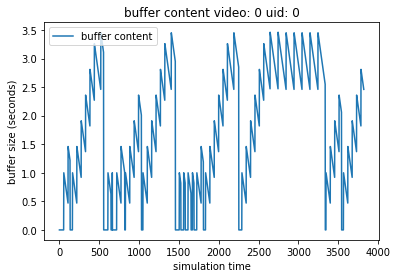

In [127]:
%matplotlib inline
def visualize_log(_log, topic, uid):
    _log = np.array(_log)
    plt.plot(_log[:, 2], label='buffer content')
    plt.xlabel('simulation time')
    plt.ylabel('buffer size (seconds)')
    plt.title('buffer content video: {} uid: {}'.format(topic, uid))
    plt.legend()


print np.mean(acc_log)

visualize_log(net_log, topic, uid)
print 'stall time: ', STALL_TIME

0.6660634787754166
stall time:  23.26


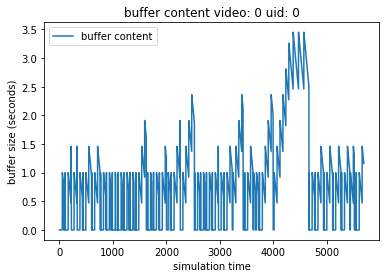

In [95]:
print np.mean(acc_log)
visualize_log(net_log, topic, uid)
print 'stall time: ', STALL_TIME

In [32]:
reload(tracesim_header)
tracesim_header.TILE_EXPAND_RADIUS

2

In [94]:
pred._sds.keys()

['paris', '1', '0', '3', '2', '5', '4', '7', '6', '8']

In [13]:
topic = '2'
uid = 35
VTIME = pred.get_VTIME_0(topic)

In [12]:
print topic, uid, VTIME, pred.get_VTIME_0(topic)

2 35

NameError: name 'VTIME' is not defined

0.07246376811594203
0.2
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
5 69 0.2


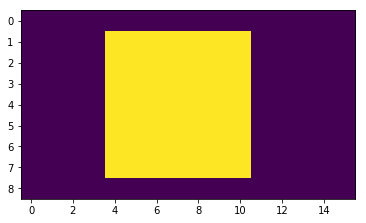

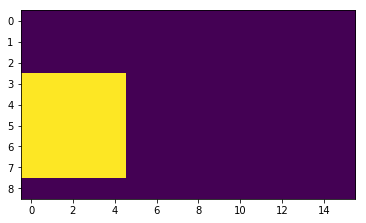

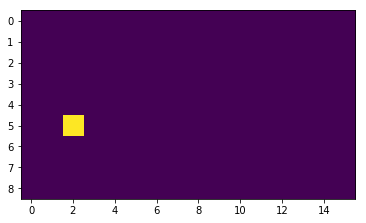

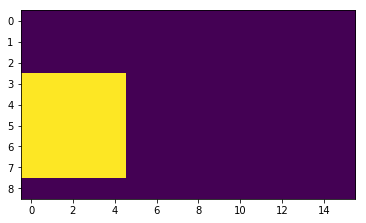

In [96]:
delta = 1.343
topic = '2'
uid = 34
VTIME = pred.get_VTIME_0(topic)
xi, yi = pred.create_sample(topic, uid, pred.get_VTIME_0(topic) + delta, look_back, look_ahead)
tile_fxi, tile_yi, acc = pred.next_tile(topic, uid, True, pred.get_VTIME_0(topic) + delta, _radius=tracesim_header.TILE_EXPAND_RADIUS+1, model='sal')
plt.imshow(tile_fxi)
plt.figure()
plt.imshow(tile_yi)
plt.figure()
plt.imshow(headpred.create_fixation_map2(yi, tracesim_header.H, tracesim_header.W))
plt.figure()
fx = pred.get_current_tilemap(topic, uid, VTIME)
plt.imshow(tile_yi)

print headpred.overlap_ratio(tile_yi, tile_fxi)
print headpred.viewport_overlap(tile_yi, tile_fxi)

print tile_yi
print tile_fxi

intersect = np.array(np.logical_and(tile_yi, tile_fxi), dtype=int)
viewport_intersect = np.array(np.logical_or(tile_yi, tile_fxi), dtype=int)

print intersect.sum(), viewport_intersect.sum(), intersect.sum()/tile_yi.sum()

In [37]:
reload(train_lstm_headsal)
lngr = train_lstm_headsal.get_lnregr_model()

(1, 147)


In [38]:
xi.shape, xi.reshape(1, -1).shape
lngr.predict(xi.reshape(1, -1))

array([[0.85243493, 0.18732117, 0.80138094]])

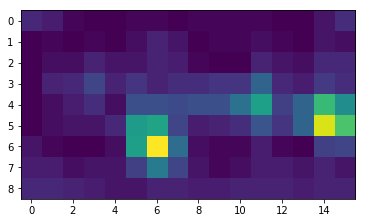

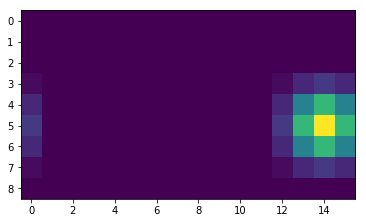

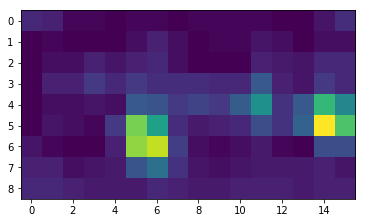

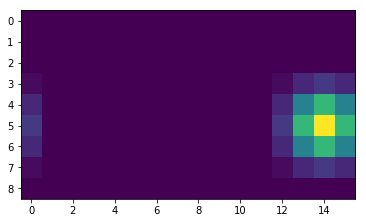

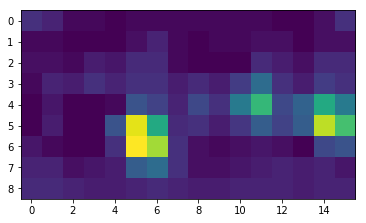

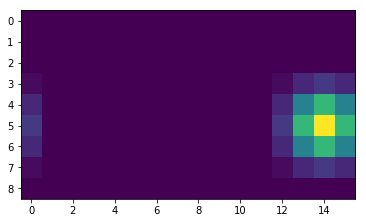

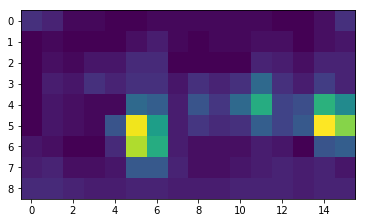

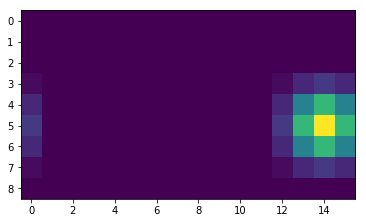

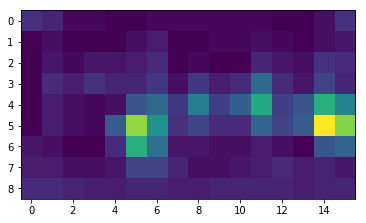

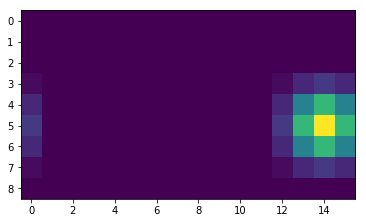

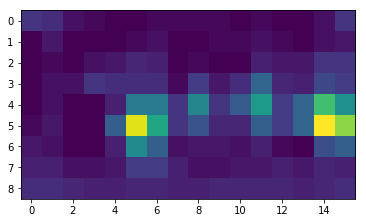

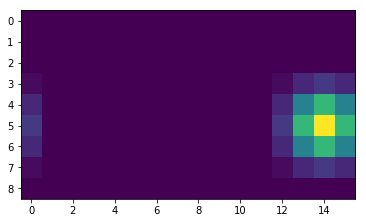

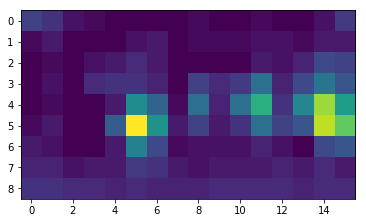

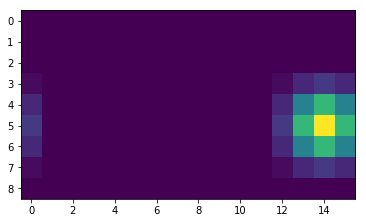

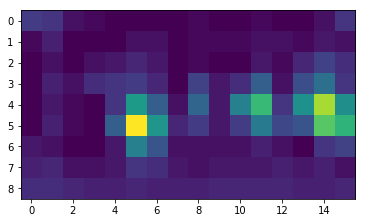

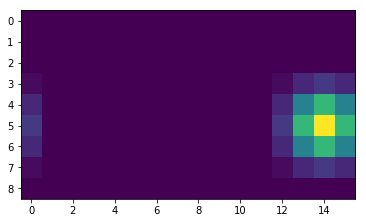

In [39]:
for item in xi:
    plt.imshow(item[3:].reshape(9, 16))
    plt.figure()
    plt.imshow(headpred.create_fixblur_map(item[:3], 9, 16, 2))
    plt.figure()

In [302]:
from keras import backend as K
from keras import models, layers, optimizers, regularizers
K.set_image_dim_ordering('th')

modelname = '360net'
N, H, W = sds[alien]['salient'].shape
print 'inputshape: ', (N, H, W)
look_back = 8
#keras.layers.ConvLSTM2D(filters, kernel_size)

n_neurons = 128
RW = 0.0001

model3 = models.Sequential()

model3.add(layers.LSTM(n_neurons, input_shape=(look_back, 3 + H * W), return_sequences=True, kernel_regularizer=regularizers.l2(RW)))
model3.add(layers.LSTM(n_neurons, kernel_regularizer=regularizers.l2(RW)))

#model3.add(layers.LSTM(n_neurons, input_shape=(look_back, 3 + H * W)))

model3.add(layers.Dense(3))
rms = optimizers.RMSprop(lr=0.001)#, rho=0.9, epsilon=None, decay=0.0)
model3.compile(loss='mean_squared_error', optimizer=rms)#'adam')
model3.summary()

inputshape:  (1430, 9, 16)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 8, 128)            141312    
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 387       
Total params: 273,283
Trainable params: 273,283
Non-trainable params: 0
_________________________________________________________________


In [9]:
topic, uid, True, VTIME

NameError: name 'VTIME' is not defined

In [10]:
pred.next_tile(topic, uid, True, VTIME, model='sal', _radius=3)

NameError: name 'VTIME' is not defined

In [27]:
len(buff._content[0])


IndexError: list index out of range

In [135]:
def simulate(topic, uid, use_model):
    STALL_TIME = 0.0

    VTIME = pred.get_VTIME_0(topic)

    network = tracesim_network.NetworkEvent(8000000, 0.04)

    buff = tracesim_buffer.Buffer(3.0, 1.0, VTIME)#size, streaming thress
    buff_state = tracesim_header.STATUS_BUFFERING

    STEP = tracesim_header.STEP
    net_log = []
    acc_log = []

    GTIME = 0.0
    use_prediction = True
    for i in range(2500):

        buff_state = buff.consume(STEP, buff_state)
        net_state = network.proceed(STEP)


        #now decide if need to send a network request
            #if network is free, and buffer is not over capacity
        if network.isReady() == True and buff.isReady() == True:
            #predict head position in next VTIME + look_ahead seconds
            fx, yi, acc = pred.next_tile(topic, uid, use_prediction, VTIME + 1.0, model=use_model)#lstm, lnregr, sal
            #however, request the tilemap after the buffer, maybe much more than look_ahead
            network.startRequest(buff._tail, fx)
            if acc != -1: 
                acc_log.append(acc)
                

        if network.isFinished() == True:
            vid_time, fx = network.endRequest()
            #self, vid_time, chunk_size, tile_map, step
            buff.fill(vid_time, 1.0, fx, STEP)

        GTIME += STEP
        VTIME = buff._head
        net_log.append([GTIME, VTIME, buff.getLength(), GTIME, VTIME])
        
        if buff_state == tracesim_header.STATUS_BUFFERING:
            STALL_TIME += STEP

    net_log = np.array(net_log)
    return acc_log, STALL_TIME



In [110]:


result = {}
lstm_stall_list = []
lnregr_stall_list = []
sal_stall_list = []
for topic in ['0', '1', '2', '3', '4', '5', '6', '7']:
    print 'simulating for topic: ', topic
    result[topic] = []
    for uid in range(5):

        VTIME = pred.get_VTIME_0(topic)
        network = tracesim_network.NetworkEvent(8000000, 0.04)

        buff = tracesim_buffer.Buffer(3.0, 1.0, VTIME)#size, streaming thress
        buff_state = tracesim_header.STATUS_BUFFERING
        lstm_result, lstm_stall_duration, lstm_stall_ratio, lstm_stall_freq = simulate2(topic, uid, use_model='lstm', radius=tracesim_header.TILE_EXPAND_RADIUS +2)
        lstm_stall_list.append([lstm_stall_ratio, lstm_stall_freq])
        
        lnregr_result, lnregr_stall_duration, lnregr_stall_ratio, lnregr_stall_freq = simulate2(topic, uid, use_model='lnregr', radius=tracesim_header.TILE_EXPAND_RADIUS +3)
        lnregr_stall_list.append([lnregr_stall_ratio, lnregr_stall_freq])
        
        sal_result, sal_stall_duration, sal_stall_ratio, sal_stall_freq = simulate2(topic, uid, use_model='sal', radius=tracesim_header.TILE_EXPAND_RADIUS +2)
        sal_stall_list.append([sal_stall_ratio, sal_stall_freq])
        
        result[topic].append([lstm_result, lnregr_result, sal_result])
        
        print lstm_stall_duration, lnregr_stall_duration, sal_stall_duration
        
    result[topic] = np.array(result[topic])

lstm_stall_list = np.array(lstm_stall_list)    
lnregr_stall_list = np.array(lnregr_stall_list)
sal_stall_list = np.array(sal_stall_list)

simulating for topic:  0
5.07 6.71 7.11
2.15 5.27 4.15
2.0 6.14 4.66
1.28 4.71 2.44
6.81 14.09 11.79
simulating for topic:  1
1.09 1.09 6.04
2.9 1.63 6.18
1.8 1.9 4.63
2.21 1.51 5.67
2.57 3.05 5.39
simulating for topic:  2
2.27 2.8 11.82
3.52 5.1 14.15
3.91 3.2 7.37
1.97 2.17 13.06
3.96 4.06 13.42
simulating for topic:  3
3.17 3.66 2.73
3.09 2.17 4.96
2.8 3.3 7.06
0.55 0.55 1.09
1.63 2.09 3.95
simulating for topic:  4
3.67 5.02 6.82
5.0 4.42 13.28
6.62 5.58 6.35
2.58 1.63 15.19
2.45 2.08 15.64
simulating for topic:  5
4.09 3.45 13.06
3.64 2.94 16.32
3.63 2.26 8.84
2.15 2.39 19.39
1.3 2.4 8.28
simulating for topic:  6
2.41 1.79 9.22
2.37 1.72 7.57
3.82 3.59 4.33
2.52 2.81 5.05
2.23 1.72 11.83
simulating for topic:  7
3.42 2.92 7.96
2.87 3.77 8.44
1.82 1.39 5.97
2.07 2.43 9.55
4.15 1.75 7.19


In [ ]:
for topic in result:
    print topic, np.mean(result[topic][:, 0]), np.mean(result[topic][:, 1])
    
print np.mean(lstm_stall), np.mean(lnregr_stall)

In [85]:
def simulate2(topic, uid, use_model='lstm', radius=2):
    STALL_TIME = 0.0
    STALL_FREQ = 0.0
    
    VTIME = pred.get_VTIME_0(topic)

    network = tracesim_network.NetworkEvent(8000000, 0.04)

    buff = tracesim_buffer.Buffer(3.0, 1.0, VTIME)#size, streaming thress
    buff_state = tracesim_header.STATUS_BUFFERING

    STEP = tracesim_header.STEP
    net_log = []
    acc_log = []


    GTIME = 0.0
    use_prediction = True
    for i in xrange(9999999999999):
        if VTIME >= pred.get_VTIME_N(topic)-2:
            break
        prev_buff_state = buff_state
        buff_state = buff.consume(STEP, buff_state)
        
        
        net_state = network.proceed(STEP)

        #after consuming, see if user actually loooking at correct predicted viewport
        if buff.isEmpty() == True:
            use_prediction = False
        elif buff.checkStalling(pred.get_current_tilemap(topic, uid, VTIME)) == True:
            use_prediction = False
            buff.clear()
            #print 'WARNING! MISPREDICTION, CLEAR BUFFER', VTIME
        else:
            use_prediction = True

        #now decide if need to send a network request
            #if network is free, and buffer is not over capacity
        if network.isReady() == True and buff.isReady() == True:
            #predict head position in next VTIME + look_ahead seconds
            fx, yi, acc = pred.next_tile(topic, uid, use_prediction, VTIME, model=use_model, _radius=radius)#lstm, lnregr, sal
            #however, request the tilemap after the buffer, maybe much more than look_ahead
            network.startRequest(buff._tail, fx)
            if acc != -1: 
                acc_log.append(acc)

        if network.isFinished() == True:
            vid_time, fx = network.endRequest()
            #self, vid_time, chunk_size, tile_map, step
            buff.fill(vid_time, 1.0, fx, STEP)
            


        GTIME += STEP
        VTIME = buff._head
        net_log.append([GTIME, VTIME, buff.getLength(), GTIME, VTIME])
        
        if buff_state == tracesim_header.STATUS_BUFFERING:
            STALL_TIME += STEP       
        if prev_buff_state != tracesim_header.STATUS_BUFFERING and buff_state == tracesim_header.STATUS_BUFFERING:
            STALL_FREQ += 1
    
    VLENGTH = pred.get_VTIME_N(topic)-2 - pred.get_VTIME_0(topic)
    return acc_log, STALL_TIME, STALL_TIME*1.0/VLENGTH, STALL_FREQ


In [111]:
stat = {}
for topic in ['0', '1', '2', '3', '4', '5', '6', '7']:
    stat[topic] = []
    for uid in range(1):
        stat[topic].append([np.mean(np.array(result[topic][uid][0])), np.mean(np.array(result[topic][uid][1])), np.mean(np.array(result[topic][uid][2]))])
    stat[topic] = np.array(stat[topic])
for topic in  ['0', '1', '2', '3', '4', '5', '6', '7']:
    print topic, np.mean(stat[topic][:, 0]), np.mean(stat[topic][:, 1]), np.mean(stat[topic][:, 2])
    
print np.mean(lstm_stall_list[:, 0]),  np.mean(lstm_stall_list[:, 1]), np.mean(lnregr_stall_list[:, 0]), \
    np.mean(lnregr_stall_list[:, 1]), np.mean(sal_stall_list[:, 0]), np.mean(sal_stall_list[:, 1])

0 0.728633750150778 0.2091507322317692 0.31971376764997506
1 0.6387669159605276 0.6191380669973133 0.271453493286849
2 0.7088690806957062 0.6485123654725048 0.3425262702427997
3 0.644201226783001 0.5598525263798 0.48547367778613104
4 0.6887931590463116 0.515376185561944 0.3525032218694689
5 0.7370624537307849 0.5927699573477303 0.2180515015834107
6 0.6344442260334933 0.6703238054767829 0.18407830968644767
7 0.5951063790355462 0.4386710182998378 0.273712720411913
0.09227820948455076 6.625 0.10209684467221147 7.625 0.2514754577020167 24.275


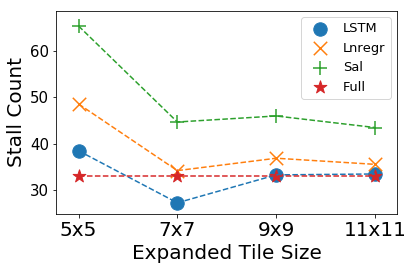

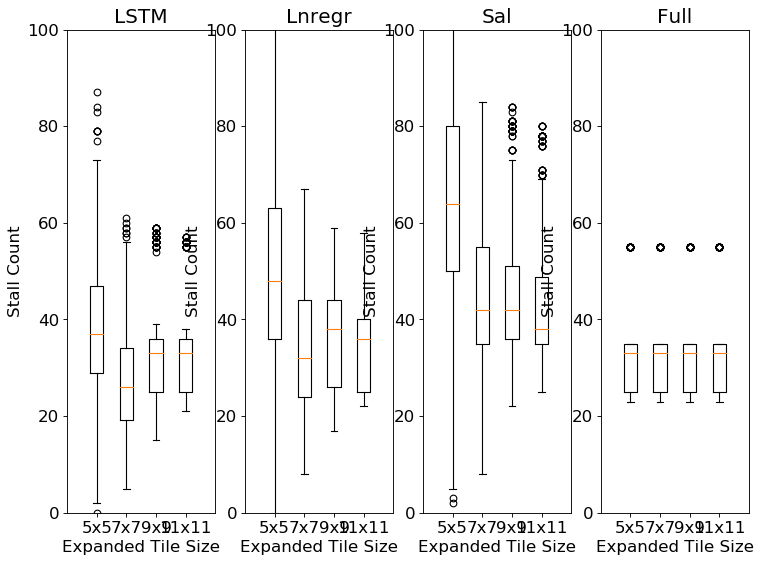

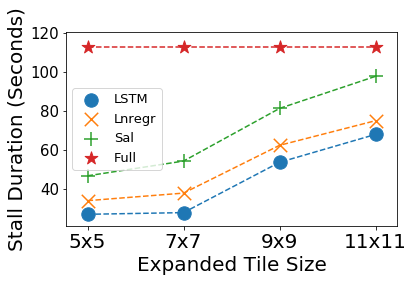

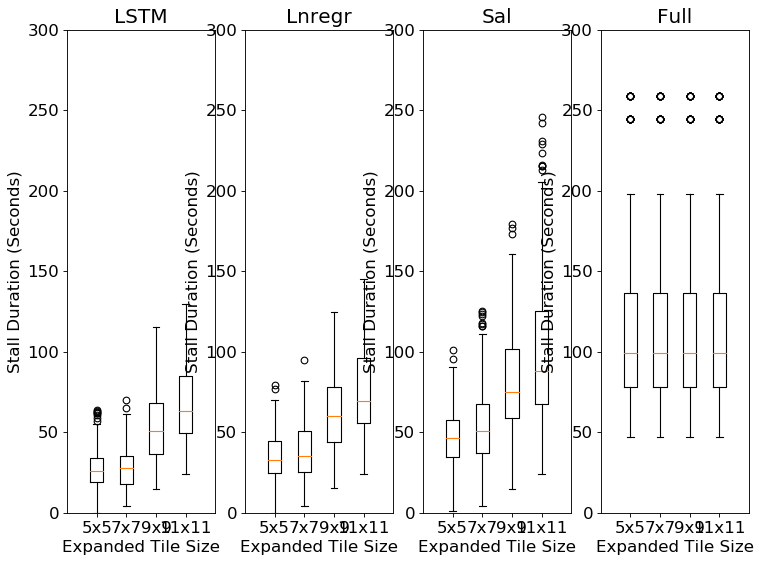

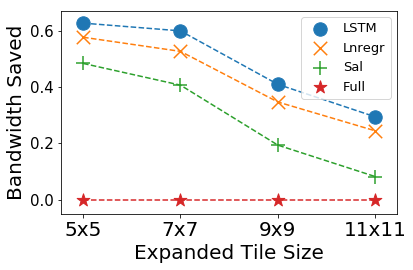

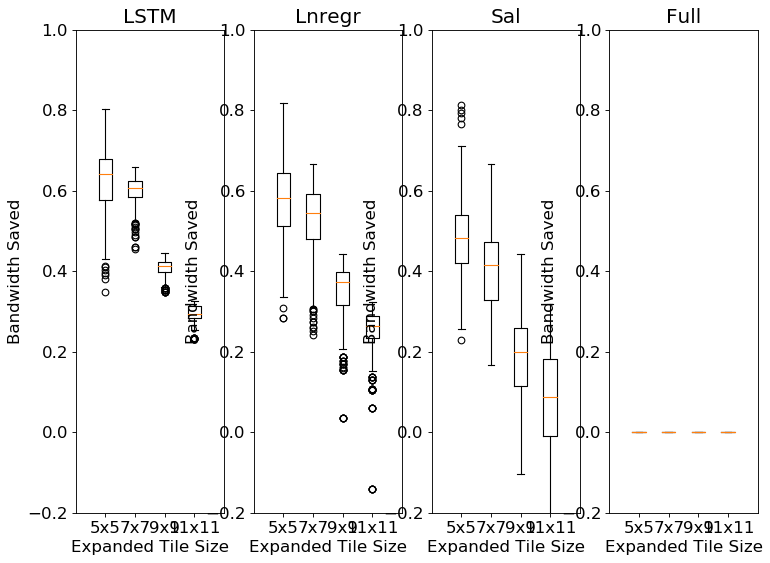

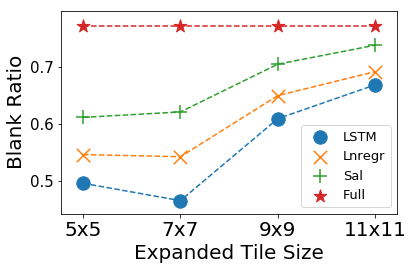

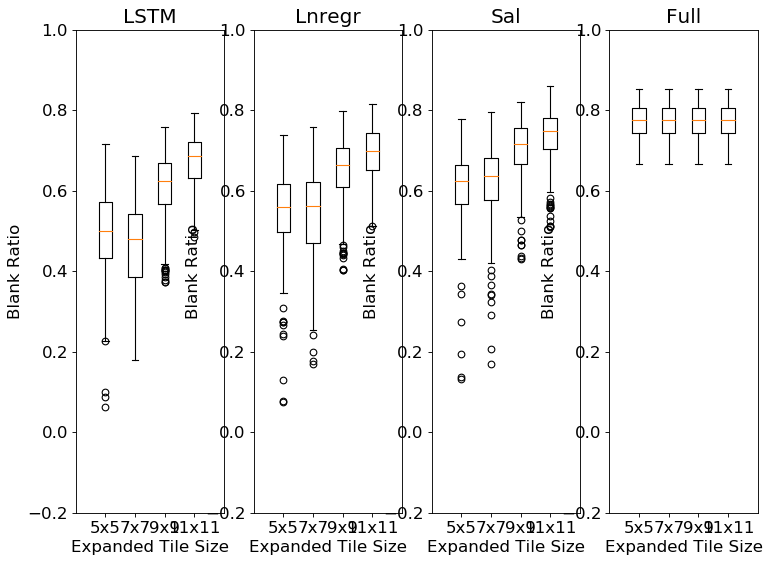

In [5]:
import test_simulator_lib
reload(test_simulator_lib)
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
look_ahead = 16
scale_mean = 8.5
scale_std = 4.5
bwscale = '{}_{}'.format(scale_mean, scale_std)
RAD_list = [2, 3, 4, 5]
radlist_str = '_'.join(map(str, RAD_list))
lstm_log, lnregr_log, sal_log, full_log = test_simulator_lib.load_log('test1', radlist_str, look_ahead, bwscale)

col_title=['a', 'b', 'c', 'd', 'e']
xlabel_list=['Stall count', 'Stall duration', 'Start time', 'Bandwidth saved', 'Blank ratio']
xticks=['5x5', '7x7', '9x9', '11x11']
x = np.arange(len(xticks))
xlabel='Expanded Tile Size'
modelname_list = ['LSTM', 'Lnregr', 'Sal', 'Full']
modelname_list = ['LSTM', 'Lnregr', 'Sal', 'Full']

        
col = 0#showing just the stalling count
title = 'fig_Stall_Count_{}_{}'.format(scale_mean, scale_std).replace('.', '_')
y_list = np.array([[log[rad][:, col] for rad in RAD_list] for log in [lstm_log, lnregr_log, sal_log, full_log]])
test_simulator_lib.plot_log(plt, x, xticks, y_list, modelname_list, title=title, xlabel=xlabel, ylabel='Stall Count', axis=[0, 5, 0, 100])   

col = 1#showing just the stalling duration
title = 'fig_Seconds_{}'.format(scale_mean, scale_std).replace('.', '_')
y_list = np.array([[log[rad][:, col] for rad in RAD_list] for log in [lstm_log, lnregr_log, sal_log, full_log]])
test_simulator_lib.plot_log(plt, x, xticks, y_list, modelname_list, title=title, xlabel=xlabel, ylabel='Stall Duration (Seconds)', axis=[0, 5, 0, 300])  

col = 3#showing just the bandwidth saved
title = 'fig_Bandwidth_Saved_{}_{}'.format(scale_mean, scale_std).replace('.', '_')
y_list = np.array([[log[rad][:, col] for rad in RAD_list] for log in [lstm_log, lnregr_log, sal_log, full_log]])
y_list2 = 1 - y_list/y_list[-1].max(axis=0)
test_simulator_lib.plot_log(plt, x, xticks, y_list2, modelname_list,  title=title, xlabel=xlabel, ylabel='Bandwidth Saved', axis=[0, 5, -0.2, 1])  

col = 4#showing just the blank ratio
title = 'fig_Blank_Ratio_{}_{}'.format(scale_mean, scale_std).replace('.', '_')
y_list = np.array([[log[rad][:, col] for rad in RAD_list] for log in [lstm_log, lnregr_log, sal_log, full_log]])
y_list2 = 1. - y_list
test_simulator_lib.plot_log(plt, x, xticks, y_list2, modelname_list,  title=title, xlabel=xlabel, ylabel='Blank Ratio', axis=[0, 5, -0.2, 1])  

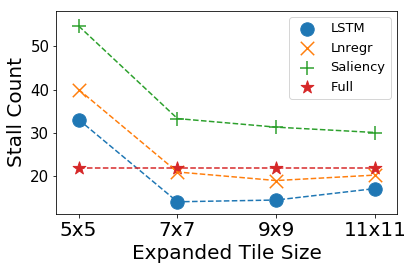

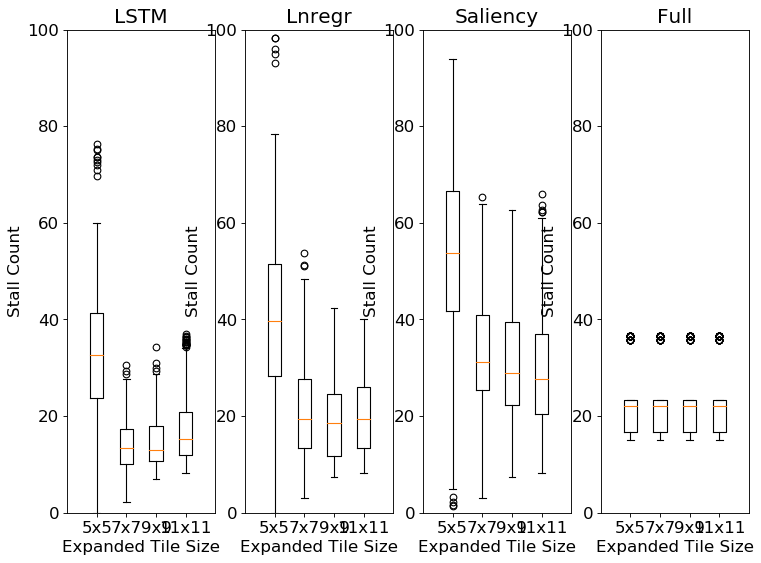

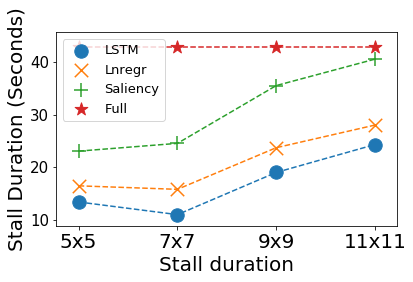

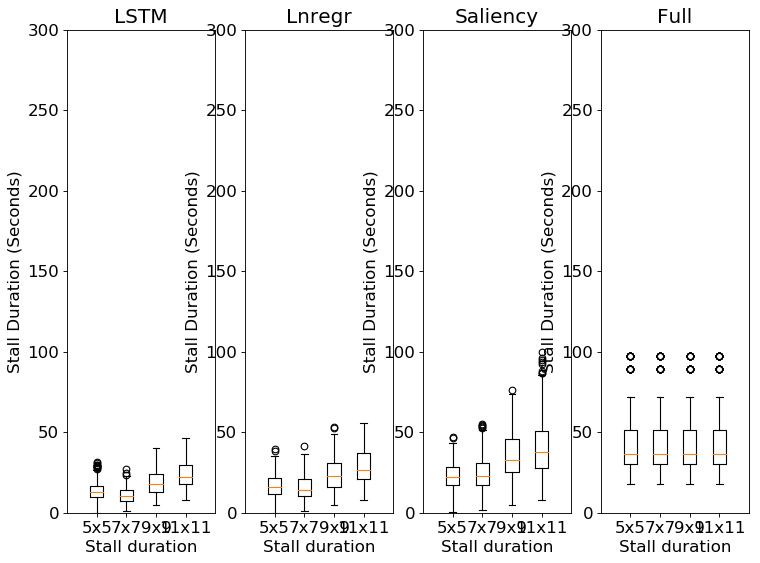

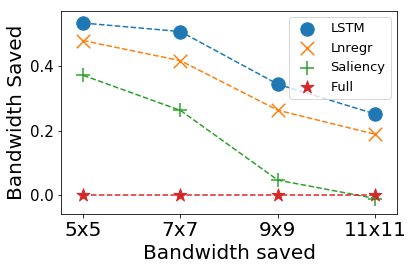

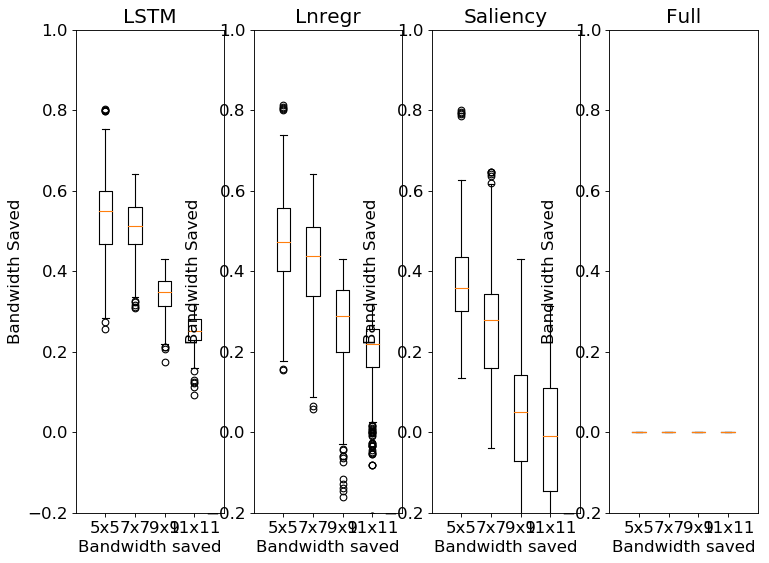

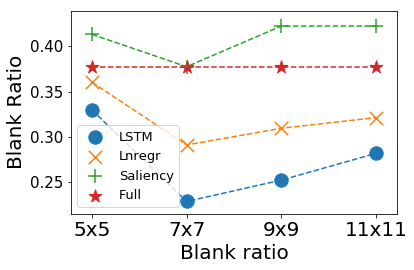

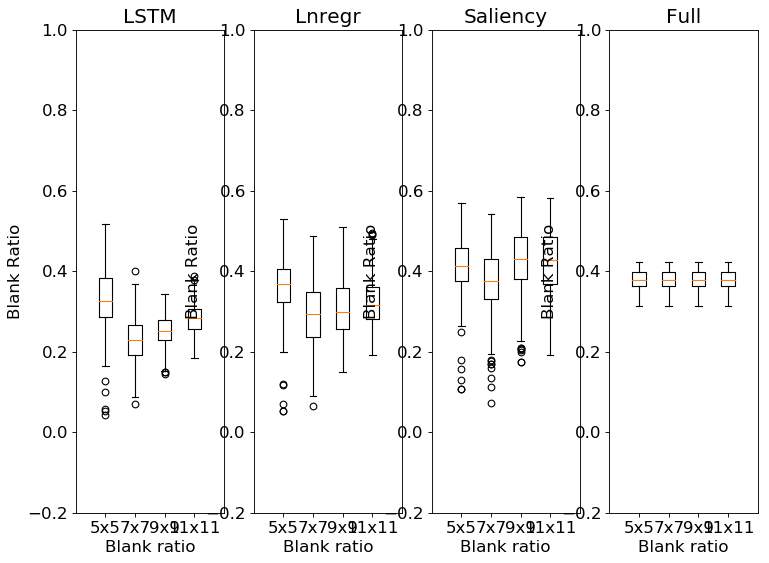

In [63]:
import test_simulator_lib
reload(test_simulator_lib)
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
look_ahead = 16
scale_mean = 44.5
scale_std = 4.5

sc_list, sd_list, bw_list, bl_list = [], [], [], []
for scale_mean in [8.5, 22.5, 44.5]:
    bwscale = '{}_{}'.format(scale_mean, scale_std)
    RAD_list = [2, 3, 4, 5]
    radlist_str = '_'.join(map(str, RAD_list))
    lstm_log, lnregr_log, sal_log, full_log = test_simulator_lib.load_log('test1', radlist_str, look_ahead, bwscale)
    
    sc_list.append(np.array([[log[rad][:, 0] for rad in RAD_list] for log in [lstm_log, lnregr_log, sal_log, full_log]]))
    sd_list.append(np.array([[log[rad][:, 1] for rad in RAD_list] for log in [lstm_log, lnregr_log, sal_log, full_log]]))
    y_list = np.array([[log[rad][:, 3] for rad in RAD_list] for log in [lstm_log, lnregr_log, sal_log, full_log]])
    bw_list.append(1 - y_list/y_list[-1].max(axis=0))
    y_list = np.array([[log[rad][:, 4] for rad in RAD_list] for log in [lstm_log, lnregr_log, sal_log, full_log]])
    bl_list.append(1. - y_list)
sc_list = np.array(sc_list).mean(axis=0)
sd_list = np.array(sd_list).mean(axis=0)
bw_list = np.array(bw_list).mean(axis=0)
bl_list = np.array(bl_list).mean(axis=0)

col_title=['a', 'b', 'c', 'd', 'e']
xlabel_list=['Stall count', 'Stall duration', 'Start time', 'Bandwidth saved', 'Blank ratio']
xticks=['5x5', '7x7', '9x9', '11x11']
x = np.arange(len(xticks))
xlabel='Expanded Tile Size'
modelname_list = ['LSTM', 'Lnregr', 'Saliency', 'Full']


        
col = 0#showing just the stalling count
title = 'fig_Stall_Count_-1_0_-1_0'
#y_list = np.array([[log[rad][:, col] for rad in RAD_list] for log in [lstm_log, lnregr_log, sal_log, full_log]])
test_simulator_lib.plot_log(plt, x, xticks, sc_list, modelname_list, title=title, xlabel=xlabel, ylabel='Stall Count', axis=[0, 5, 0, 100])   

col = 1#showing just the stalling duration
title = 'fig_Seconds_-1_0_-1_0'
#y_list = np.array([[log[rad][:, col] for rad in RAD_list] for log in [lstm_log, lnregr_log, sal_log, full_log]])
test_simulator_lib.plot_log(plt, x, xticks, sd_list, modelname_list, title=title, xlabel=xlabel_list[col], ylabel='Stall Duration (Seconds)', axis=[0, 5, 0, 300])  

col = 3#showing just the bandwidth saved
title = 'fig_Bandwidth_Saved_-1_0_-1_0'
#y_list = np.array([[log[rad][:, col] for rad in RAD_list] for log in [lstm_log, lnregr_log, sal_log, full_log]])
#y_list2 = 1 - y_list/y_list[-1].max(axis=0)
test_simulator_lib.plot_log(plt, x, xticks, bw_list, modelname_list,  title=title, xlabel=xlabel_list[col], ylabel='Bandwidth Saved', axis=[0, 5, -0.2, 1])  

col = 4#showing just the blank ratio
title = 'fig_Blank_Ratio_-1_0_-1_0'
#y_list = np.array([[log[rad][:, col] for rad in RAD_list] for log in [lstm_log, lnregr_log, sal_log, full_log]])
#y_list2 = 1. - y_list
test_simulator_lib.plot_log(plt, x, xticks, bl_list, modelname_list,  title=title, xlabel=xlabel_list[col], ylabel='Blank Ratio', axis=[0, 5, -0.2, 1])  

In [42]:
full_log_list = np.array(full_log_list)


TypeError: unsupported operand type(s) for +: 'dict' and 'dict'

In [43]:
full_log_list

array([{2: array([[33.000, 136.550, 4.740, 0.209, 0.189],
       [33.000, 136.550, 4.740, 0.209, 0.189],
       [33.000, 136.550, 4.740, 0.209, 0.189],
       ...,
       [35.000, 99.350, 2.040, 0.220, 0.257],
       [35.000, 99.350, 2.040, 0.220, 0.257],
       [35.000, 99.350, 2.040, 0.220, 0.257]]), 3: array([[33.000, 136.550, 4.740, 0.209, 0.189],
       [33.000, 136.550, 4.740, 0.209, 0.189],
       [33.000, 136.550, 4.740, 0.209, 0.189],
       ...,
       [35.000, 99.350, 2.040, 0.220, 0.257],
       [35.000, 99.350, 2.040, 0.220, 0.257],
       [35.000, 99.350, 2.040, 0.220, 0.257]]), 4: array([[33.000, 136.550, 4.740, 0.209, 0.189],
       [33.000, 136.550, 4.740, 0.209, 0.189],
       [33.000, 136.550, 4.740, 0.209, 0.189],
       ...,
       [35.000, 99.350, 2.040, 0.220, 0.257],
       [35.000, 99.350, 2.040, 0.220, 0.257],
       [35.000, 99.350, 2.040, 0.220, 0.257]]), 5: array([[33.000, 136.550, 4.740, 0.209, 0.189],
       [33.000, 136.550, 4.740, 0.209, 0.189],
       

In [34]:
import os
import numpy as np
#from matplotlib import pyplot as plt
#%matplotlib inline

#include pred, get video duration, show code to extract frame
H_list = [0,  160,  320,  480,  640,  800,  960, 1120, 1280]
W_list = [0,  160,  320,  480,  640,  800,  960, 1120, 1280, 1440, 1600,
               1760, 1920, 2080, 2240, 2400]
topic_dict = {'1': 'skiing.mp4', '0': 'conan1.mp4', '3': 'conan2.mp4', '2': 'alien.mp4', '4': 'surfing.mp4', '7': 'football.mp4', '6': 'cooking.mp4', '8': 'rhinos.mp4'}
time_dict = {'1': (9, 33), '0': (9, 43), '3': (17, 43), '2': (72, 128), '4': (37, 73), '7': (78, 114), '6': (17, 43), '8': (37, 78)}
topic = '1'
uid = 13
t = (time_dict[topic][0] + time_dict[topic][1])/2
wi = 160
hi = 960
print 'range:' , (time_dict[topic][0], time_dict[topic][1])
print topic, uid, topic_dict[topic], t

for topic in ['2', '3', '4', '6', '7', '8']:
    for t in range(time_dict[topic][0], time_dict[topic][1]):
        print 'generate scripts for topic: {}, t: {}'.format
        cmd_list = []
        vname = topic_dict[topic].replace('.mp4', '')
        vin_name0 = topic_dict[topic]
        vout_name0 = '{}_{}.jpg'.format(vin_name0.replace('.mp4', ''), t)
        cmd0 = 'yes | ffmpeg -ss {} -i ./{} -vframes 1  ./video_tiles_tracesim/{}/{}'.format(t, vin_name0, vname, vout_name0)
        cmd_list.append(cmd0)
        for wi in W_list:
            for hi in H_list:
                vin_name = '{}_{}_{}.mp4'.format(topic_dict[topic].replace('.mp4', ''), wi, hi)
                vout_name = '{}_{}.jpg'.format(vin_name.replace('.mp4', ''), t)
                cmd = 'yes | ffmpeg -ss {} -i ./video_tiles/{} -vframes 1  ./video_tiles_tracesim/{}/{}'.format(t, vin_name, vname, vout_name)
                cmd_list.append(cmd)
        cmd_str =  ';'.join(cmd_list)
        #print cmd_str
        os.system(cmd_str)

SyntaxError: invalid syntax (<ipython-input-34-7d142ef33710>, line 20)

(1440, 2560, 3) <type 'numpy.ndarray'> 0 255
all close? False


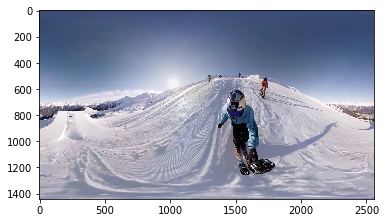

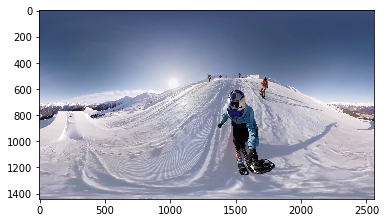

In [31]:
####test stiching PNSR
from PIL import Image
import numpy as np

def load_image( infilename ) :
    img = Image.open( infilename )
    img.load()
    data = np.asarray( img, dtype="int" ).astype(np.uint8)
    return data

def stitch_image(_img0, _template_path, _topic, _h_list, _w_list, _ts):
    #'./PSNR_frame_tiles/skiing/{}_{}_{}_{}.jpg'
    H, W, C = _img0.shape
    D = 160
    result = np.zeros(shape=(H, W, C), dtype=np.uint8)
    for wi in _w_list:
        for hi in _h_list:
            img_path = _template_path.format(_topic, _topic, wi, hi, _ts)
            img = load_image(img_path)
            result[hi:hi+D, wi:wi+D] = img

    return result
    

img0_path = './PSNR_frame_tiles/skiing/skiing_21.jpg'

#img0 = load_image()
#print img0.shape
#plt.imshow(img0)

img0 = load_image(img0_path)#.astype(np.uint8)
print img0.shape, type(img0), img0.min(), img0.max()

plt.imshow(img0)
plt.figure()
img1 = stitch_image(img0, './PSNR_frame_tiles/{}/{}_{}_{}_{}.jpg', 'skiing', H_list, W_list, 21)
plt.imshow(img1)
print 'all close?', np.allclose(img0, img1)

0 255
129 248
0 248
True


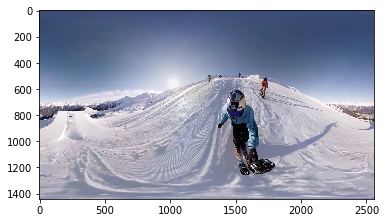

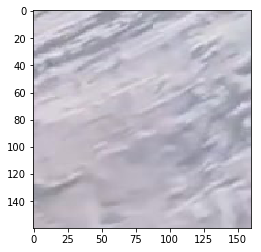

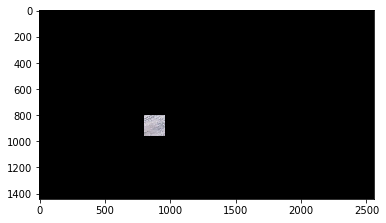

In [30]:
img0_path = './PSNR_frame_tiles/skiing/skiing_21.jpg'
img_path = './PSNR_frame_tiles/{}/{}_{}_{}_{}.jpg'.format('skiing', 'skiing', 800, 800, 21)
#img0 = load_image()
#print img0.shape
#plt.imshow(img0)

img0 = load_image(img0_path)#.astype(np.uint8)
img = load_image(img_path)
plt.imshow(img0)
plt.figure()
plt.imshow(img)
plt.figure()

temp = np.asarray(np.zeros(shape=img0.shape), dtype="int").astype(np.uint8)
temp[800:960, 800:960] = img
print img0.min(), img0.max()
print img.min(), img.max()
print temp.min(), temp.max()
plt.imshow(temp)
print np.allclose(temp[800:960, 800:960], img)

In [33]:
import numpy 
import math
import cv2

def psnr(img1, img2):
    mse = numpy.mean( (img1 - img2) ** 2 )
    if mse == 0:
        return 100
    PIXEL_MAX = 255.0
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

print psnr(img0, img1)

32.8396292589


In [ ]:
0.775317192078 seconds for reading

In [31]:
import tracesim_psnr
import timeit
reload(tracesim_psnr)
topic = '1'
Psnr = tracesim_psnr.PSNR()
t0, t1 = Psnr.get_range(topic)


0.166035175323 0.00217390060425 0.0389769077301 0.0125269889832 2.14576721191e-06
0.392950057983
31.9224183626 0.7518151267056451 33.695522478 0.9561612088579299


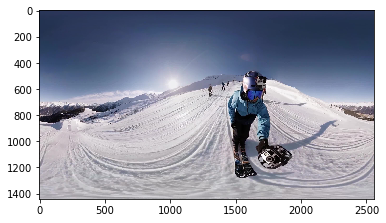

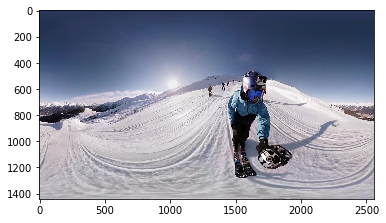

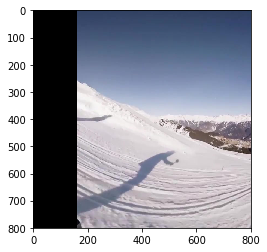

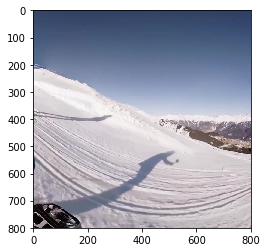

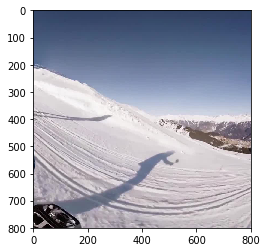

In [32]:
VTIME = t0 + 13.23
uid = 12
use_prediction=True
radius=3


fx, yi, acc = pred.next_tile(topic, uid, use_prediction, VTIME, model='lnregr', _radius=radius)
tima = timeit.default_timer()
a, b, c, d, e, f, g, h, k = Psnr.viewport_perceived(topic, t0+5.12345, yi, fx)
print timeit.default_timer() - tima

print a, b, c, d
plt.imshow(e)
plt.figure()
plt.imshow(f)
plt.figure()
plt.imshow(g)
plt.figure()
plt.imshow(h)
plt.figure()
plt.imshow(k)
plt.figure()

In [22]:


im0, im1 = Psnr.get_imagepair(topic, t0 + 5)
pr = Psnr.psnr(im0, im1)
sm = compare_ssim(im0, im1, im1.max() - im1.min(), multichannel=True)
plt.imshow(im0)
plt.title('original image')
plt.figure()
plt.imshow(im1)
plt.title('stitched image, psnr={}, sm={}'.format(pr, sm))

radius=3


VTIME = t0 + 15#14#10.43
use_prediction = True
uid = 12
fx, yi, acc = pred.next_tile(topic, uid, use_prediction, VTIME, model='lstm', _radius=radius)
fx2 = pred.get_current_tilemap(topic, uid, VTIME)

prediction_mask = Psnr.create_mask(im1, fx2)
im2 = np.copy(im1)
im2[prediction_mask==0] = tracesim_psnr.PSNR._BACKGROUND_VAL


plt.figure()
plt.title('DEBUG: downloaded frame')
plt.imshow(im2)

#now, show what is the image user see

viewport_mask = Psnr.create_mask(im2, yi)
viewport_full = Psnr.extract_vpimage(im1, viewport_mask)
viewport_pred = Psnr.extract_vpimage(im2, viewport_mask)
viewport0 = Psnr.extract_vpimage(im0, viewport_mask)
pr_pred = Psnr.psnr(viewport_pred, viewport0)
sm_pred = compare_ssim(viewport0, viewport_pred, viewport_pred.max() - viewport_pred.min(), multichannel=True)
pr_full = Psnr.psnr(viewport_full, viewport0)
sm_full = compare_ssim(viewport0, viewport_full, viewport_full.max() - viewport_full.min(), multichannel=True)




plt.figure()
plt.imshow(viewport_pred)
plt.title('content in viewport from prediction, psnr={}, ssim={}'.format(pr_pred, sm_pred))
plt.figure()
plt.imshow(viewport_full)
plt.title('content in viewport from downloaded everything, psnr={}, ssim={}'.format(pr_full, sm_full))
plt.figure()
plt.imshow(viewport0)
plt.title('content in original image')


NameError: name 'compare_ssim' is not defined

In [39]:
viewport_pred.max() - viewport_pred.min()+1

256

In [1]:
#this code to test and normalize the tracesim

In [2]:
ls ./4G_log/

report_bicycle_0001.log  report_car_0002.log   report_foot_0008.log
report_bicycle_0002.log  report_car_0003.log   report_train_0001.log
report_bus_0001.log      report_car_0004.log   report_train_0002.log
report_bus_0002.log      report_car_0005.log   report_train_0003.log
report_bus_0003.log      report_car_0006.log   report_tram_0001.log
report_bus_0004.log      report_car_0007.log   report_tram_0002.log
report_bus_0005.log      report_car_0008.log   report_tram_0003.log
report_bus_0006.log      report_foot_0001.log  report_tram_0004.log
report_bus_0007.log      report_foot_0002.log  report_tram_0005.log
report_bus_0008.log      report_foot_0003.log  report_tram_0006.log
report_bus_0009.log      report_foot_0004.log  report_tram_0007.log
report_bus_0010.log      report_foot_0005.log  report_tram_0008.log
report_bus_0011.log      report_foot_0006.log
report_car_0001.log      report_foot_0007.log


In [5]:

bwtrace_list = ['./4G_log/report_car_0002.log',
                './4G_log/report_car_0004.log',
                './4G_log/report_bus_0002.log',
                './4G_log/report_bus_0004.log',
               './4G_log/report_foot_0001.log']
for trace in bwtrace_list:
    bw = tracesim_bandwidth.Bandwidth(trace, scale_mean=-1.0, scale_std=-1.0)
    m, std = np.mean(bw._trace), np.std(bw._trace)
    print m*8.0/1000000, std*8.0/1000000

29.741356439639638 13.856969337727989
28.79645267368421 14.253608057591267
30.81194097943925 13.49433681584003
60.525278169741696 27.21056050767096
41.655406346938776 13.307991504254382


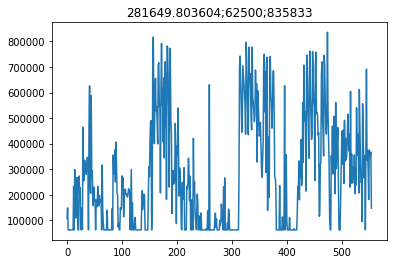

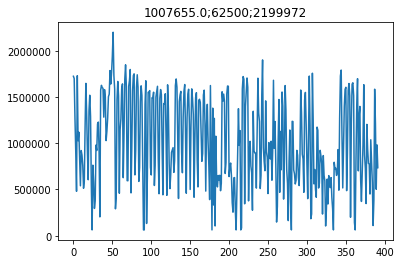

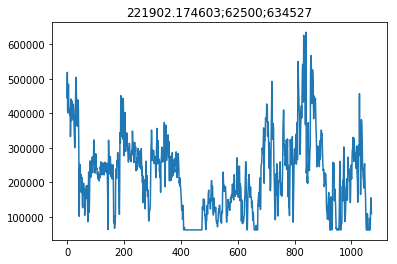

In [7]:



y = np.array(bw._trace)
y2 = np.array(bw2._trace)
yn = np.array(bwn._trace)
plt.plot(y)
plt.title('{};{};{}'.format(y.mean(), y.min(), y.max()))
plt.figure()
plt.plot(y2)
plt.title('{};{};{}'.format(y2.mean(), y2.min(), y2.max()))
plt.figure()
plt.plot(yn)
plt.title('{};{};{}'.format(yn.mean(), yn.min(), yn.max()))

In [115]:
idx = 23
sum(bw._trace[idx:idx+5])*1.0/len(bw._trace[idx:idx+5])

493296.4

In [49]:
(y2 <= 0).sum()

0